**Group 21:** Grégoire Bellan, Benjamin Cohen, Victor Manach, Hugues René-Bazin

In [1]:
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Scikit-learn library
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Library for Neural Networks
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation

# Load data

In [2]:
names = ['Ant', 'Grapes']

In [3]:
X_ant = np.load('./data/G_21_ant.npy')
X_grapes = np.load('./data/G_21_grapes.npy')

In [4]:
X_test = np.load('./data/test_images.npy')
y_test = np.load('./data/test_labels.npy').astype(int)

# Create labels for ant and grapes

The labels defined in the test set are ``ant = label 0`` and ``grapes = label 1``, so we will use the same labelling for the train set.

It is necessary to have this labelling for the neural network (with the ``to_categorical`` function that needs positive integers for classes), and it works without problem for the other models (SVM and trees).

In [5]:
y_ant = np.zeros((X_ant.shape[0],))
y_grapes = np.ones((X_grapes.shape[0],))

# Merge the data into one matrix

In [6]:
X_train = np.concatenate((X_ant, X_grapes), axis=0)

In [7]:
y_train = np.concatenate((y_ant, y_grapes), axis=0).astype(int)

We want to shuffle the data to be sure that the data set is representative of both classes.

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

Standardisation of the data is necessary for the PCA. We use the same transformation on X_train and on X_test.

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA for dimensionality reduction

We want to keep the first two principal components of the PCA in order to be able to represent the data in 2D, which may give us clues about rather the data is linearly separable or not.

In [10]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

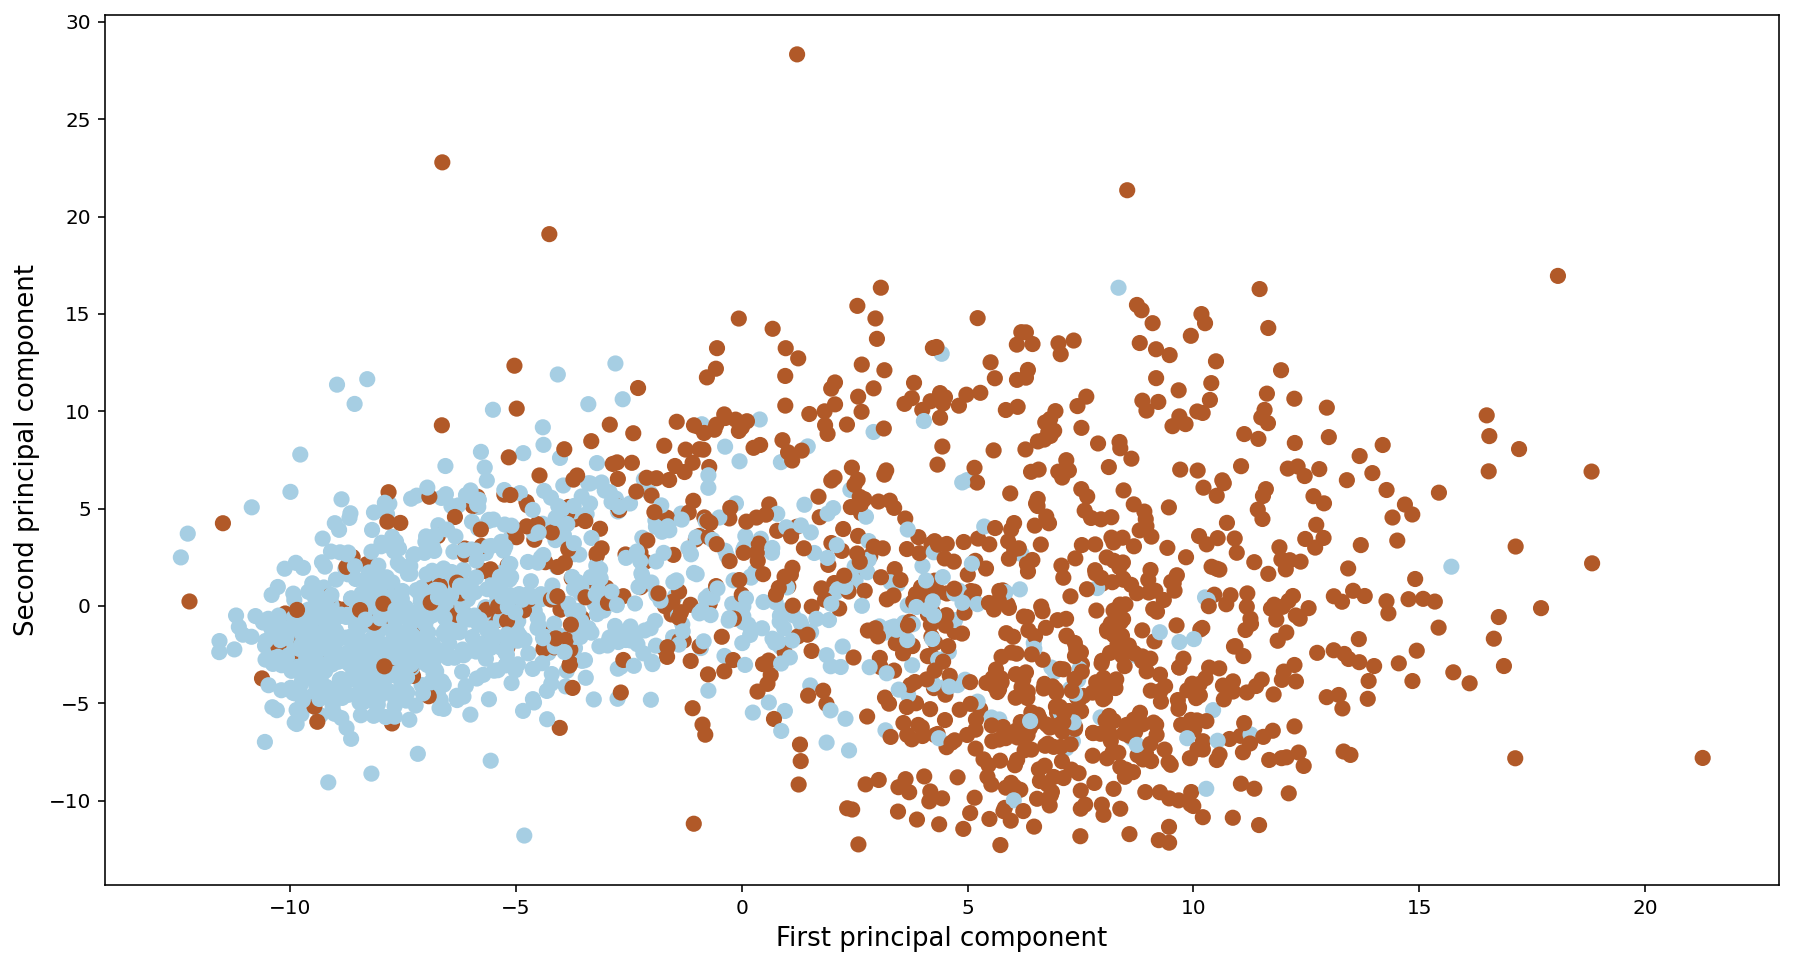

In [11]:
plt.figure(figsize=(15,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=50, cmap=plt.cm.Paired)
plt.xlabel('First principal component', size=13)
plt.ylabel('Second principal component', size=13)
plt.show()

From the plot, we can see that the data is not linearly separable. We will therefore only use non-linear classifiers.

First, we will start by using SVM with a Gaussian kernel.

**Assess predictive models**\
To assess the predictive models, we use the accuracy of the model on both the train set and the test set. The accuracy on the train set allows us to detect if our model is overfitting and the accuracy on the test set allows us to compare the different models we will test to each other. In addition, we look at the time needed to select the best hyperparameters (from a reduced range of values) and the time needed to train the model in order to have a compromise between precision and speed.

# SVM with a Gaussian kernel

We use cross-validation to determine the best values for the hyperparameters.

In [12]:
clf_rbf = GridSearchCV(SVC(), param_grid={'kernel': ['rbf'], 'C':np.linspace(1,1,10), 'gamma':['scale', 'auto']})

In [13]:
%%time
clf_rbf.fit(X_train, y_train)
print(clf_rbf.best_params_)

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
CPU times: user 1min 43s, sys: 324 ms, total: 1min 43s
Wall time: 1min 44s


In [14]:
print('Accuracy on train set:', clf_rbf.score(X_train, y_train))
print('Accuracy on test set:', clf_rbf.score(X_test, y_test))

Accuracy on train set: 0.956
Accuracy on test set: 0.86


At first glance, this first model gives quite good results on the test set. However, the score the train set is close to 1, which means that there is overfitting in our model. Even when selecting the best hyperparameters with cross-validation, we still have overfitting. We have tried using other kernels, but the accuracy is always lower and we still witness overfitting. In addition the training time is quite long (betwee, 1m 30 and 2min).

**Ways to improve our results**\
Therefore, the SVM might not be the most appropirate model for this particualr task because the data is not easily separable, even when changing the feature space (by using a PDS kernel), and so we will use decision tree (and Random Forest) to try to obtain results as good as those obtained with SVM, but with less overfitting so that the model will perform better on new data.

# Decision Tree

We try first with a Decision Tree and use cross-validation to determine the best hyperparameters (and especially the ``max_depth`` to avoid overfitting). Decision trees might give us better results than SVM because they often work well when there is a large number of features (which is the case with our 784 features).

In [15]:
d_tree_params = {'criterion' : ['gini', 'entropy'], 'splitter' : ['best', 'random'], 'max_depth' : np.arange(1,6)}
dec_tree = GridSearchCV(DecisionTreeClassifier(),d_tree_params)

In [16]:
%%time
dec_tree.fit(X_train,y_train)
print(dec_tree.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}
CPU times: user 7.07 s, sys: 69.4 ms, total: 7.14 s
Wall time: 7.16 s


In [17]:
print('Accuracy on train set:', dec_tree.score(X_train, y_train))
print('Accuracy on test set:', dec_tree.score(X_test, y_test))

Accuracy on train set: 0.833
Accuracy on test set: 0.766


By reducing the ``max_depth`` paramater, we were able to reduce the training time. Therefore, the model is much faster than the SVM but we obtain poorer results. We might be able to improve them by using a Random Forest Classifier.

# Random Forest Classifier

In [18]:
rf_params = {'criterion' : ['gini', 'entropy'], 'max_depth' : np.arange(2,6)}
rfc = GridSearchCV(RandomForestClassifier(),rf_params)

In [19]:
%%time
rfc.fit(X_train,y_train)
print(rfc.best_params_)

{'criterion': 'gini', 'max_depth': 5}
CPU times: user 20.1 s, sys: 139 ms, total: 20.3 s
Wall time: 20.3 s


In [20]:
print('Accuracy on train set:', rfc.score(X_train, y_train))
print('Accuracy on test set:', rfc.score(X_test, y_test))

Accuracy on train set: 0.8955
Accuracy on test set: 0.843


Using Random Forest gives us significantly better results than with the Decision tree. It is a bit longer to train the model but still much faster than the SVM model. In addition, we have limited to 5 the maximum depth because increasing it more than that was increasing the train accuracy, but very little the test accuracy.\
Thus, we obtain results that are nearly as good as the results obtained with SVM, but there is less overfitting, so the model might perform better on unseen data.

**Final attempt to improve the results**\
Finally, we want to train a neural network to determine whether we can get better results without too much overfitting.

# Neural network

**Architecture**\
For the architecture of the neural network, we have 784 values in input and only 2 values in output (because we use the one-hot encoding). We use the sigmoid activation function for the output layer because we want a value between 0 and 1, that will represent the probability of being either of class 0 or of class 1. In addition, we use the ``categorical_crossentropy`` loss function because we use the one-hot encoding for the labels. Finally, we use the accuracy to measure the performance of the model.

Then, we have tested different architecture (with more hidden layers, with different number of neurons per layer), and we have found that the following architecture gives us the best results on average. Also, we have tried different optimiers (SGD and adam) and ``adam`` is the one that performs best, as it combines the advantages of other optimizers.  

In [21]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)

In [22]:
model = Sequential()
input_shape = 784
layer_1_shape = 500
output_shape = 2
model.add(Dense(layer_1_shape, activation='relu', input_dim=input_shape))
model.add(Dense(output_shape, activation='sigmoid'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
%%time
epochs=10
history = model.fit(X_train, y_train_NN, epochs=epochs, batch_size=10, validation_data=(X_test, y_test_NN))

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 0.6158 - accuracy: 0.7946 - val_loss: 0.4606 - val_accuracy: 0.8390
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1389 - accuracy: 0.9472 - val_loss: 0.4802 - val_accuracy: 0.8420
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1005 - accuracy: 0.9701 - val_loss: 0.5520 - val_accuracy: 0.8620
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0356 - accuracy: 0.9924 - val_loss: 0.4906 - val_accuracy: 0.8380
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0280 - accuracy: 0.9941 - val_loss: 0.5725 - val_accuracy: 0.8580
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.6133 - val_accuracy: 0.8660
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.6111 - val_accuracy: 0.8640
Epoch 

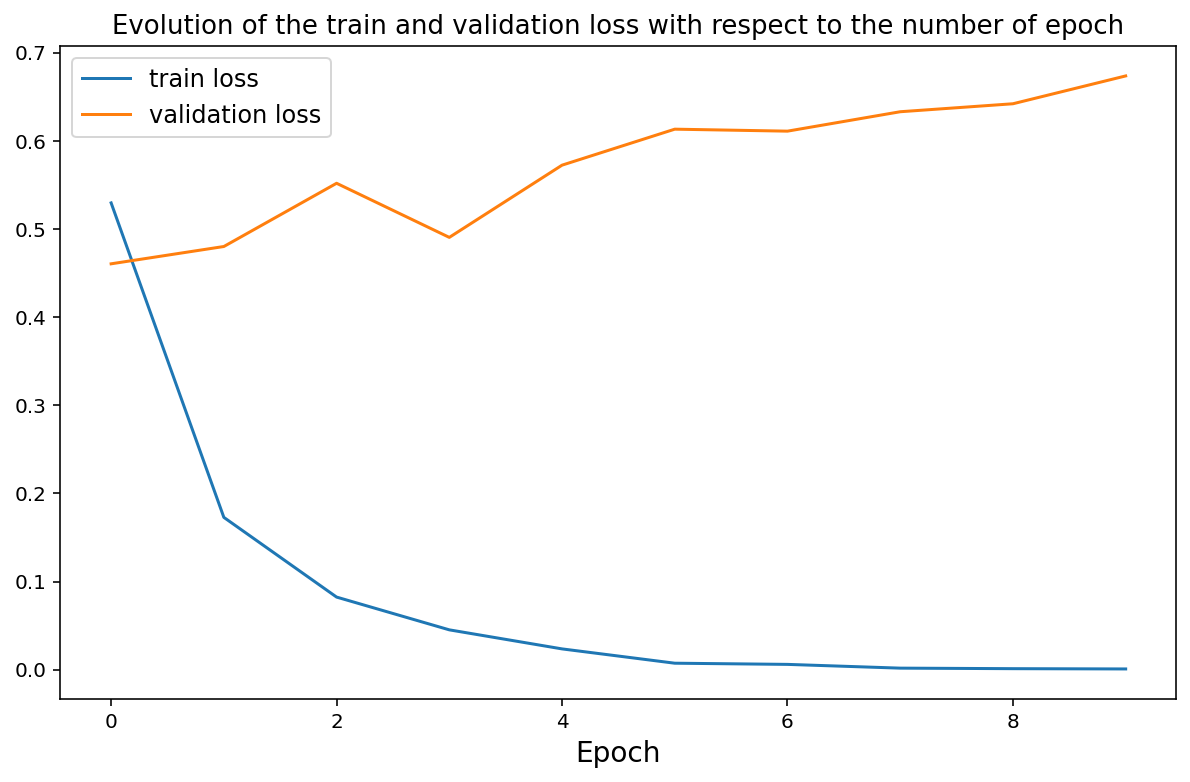

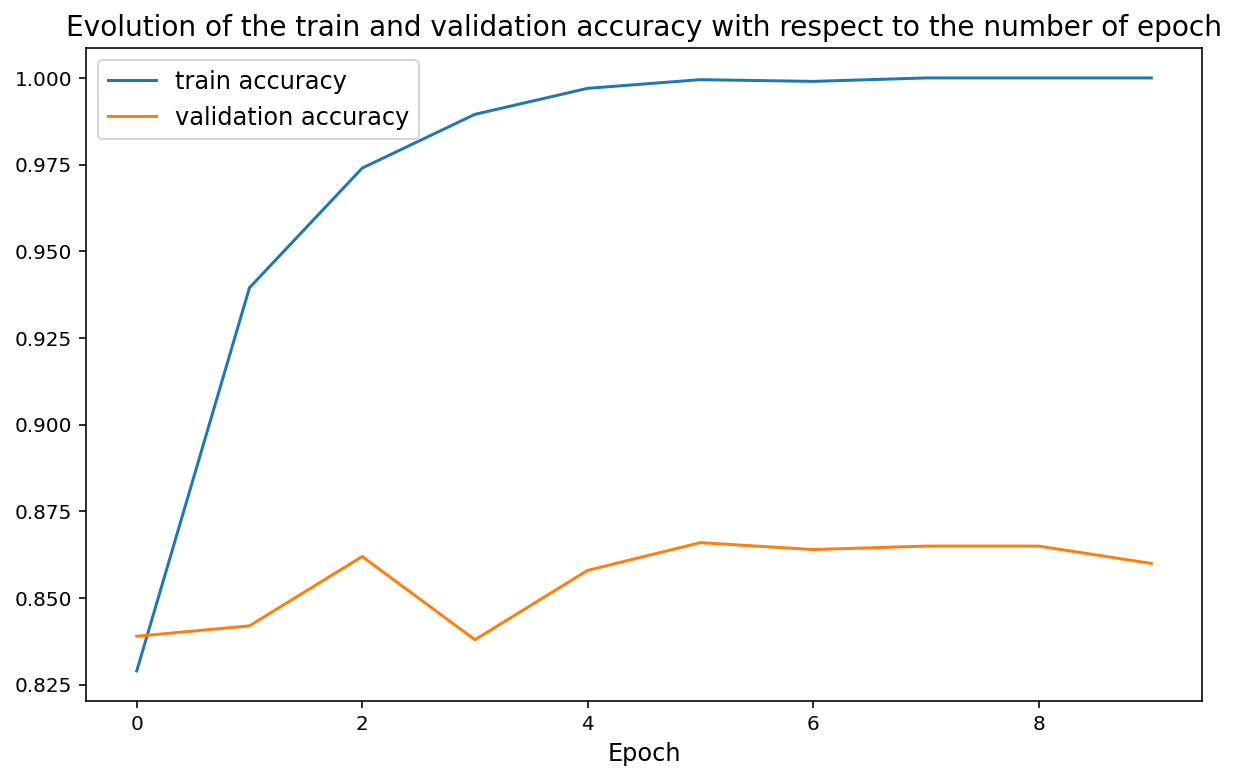

In [25]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch', size=14)
plt.title('Evolution of the train and validation loss with respect to the number of epoch', size=13)

plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=12)
plt.title('Evolution of the train and validation accuracy with respect to the number of epoch', size=14)

plt.legend(fontsize=12)
plt.show()

The plot shows that there is a lot of overfitting too which this model, and it does not perform a lot better on the test set than the Random Forest model. In addition, the validation loss is increasing with respect to the epoch, while the accuracy on the test set is nearly constant. This shows that there is overfitting (high train accuracy, very low train loss) and that the model is memorising the train set, so it does not increase its performance on the test set.\
However, it is faster to train.

# Represent the images and their true and predicted labels

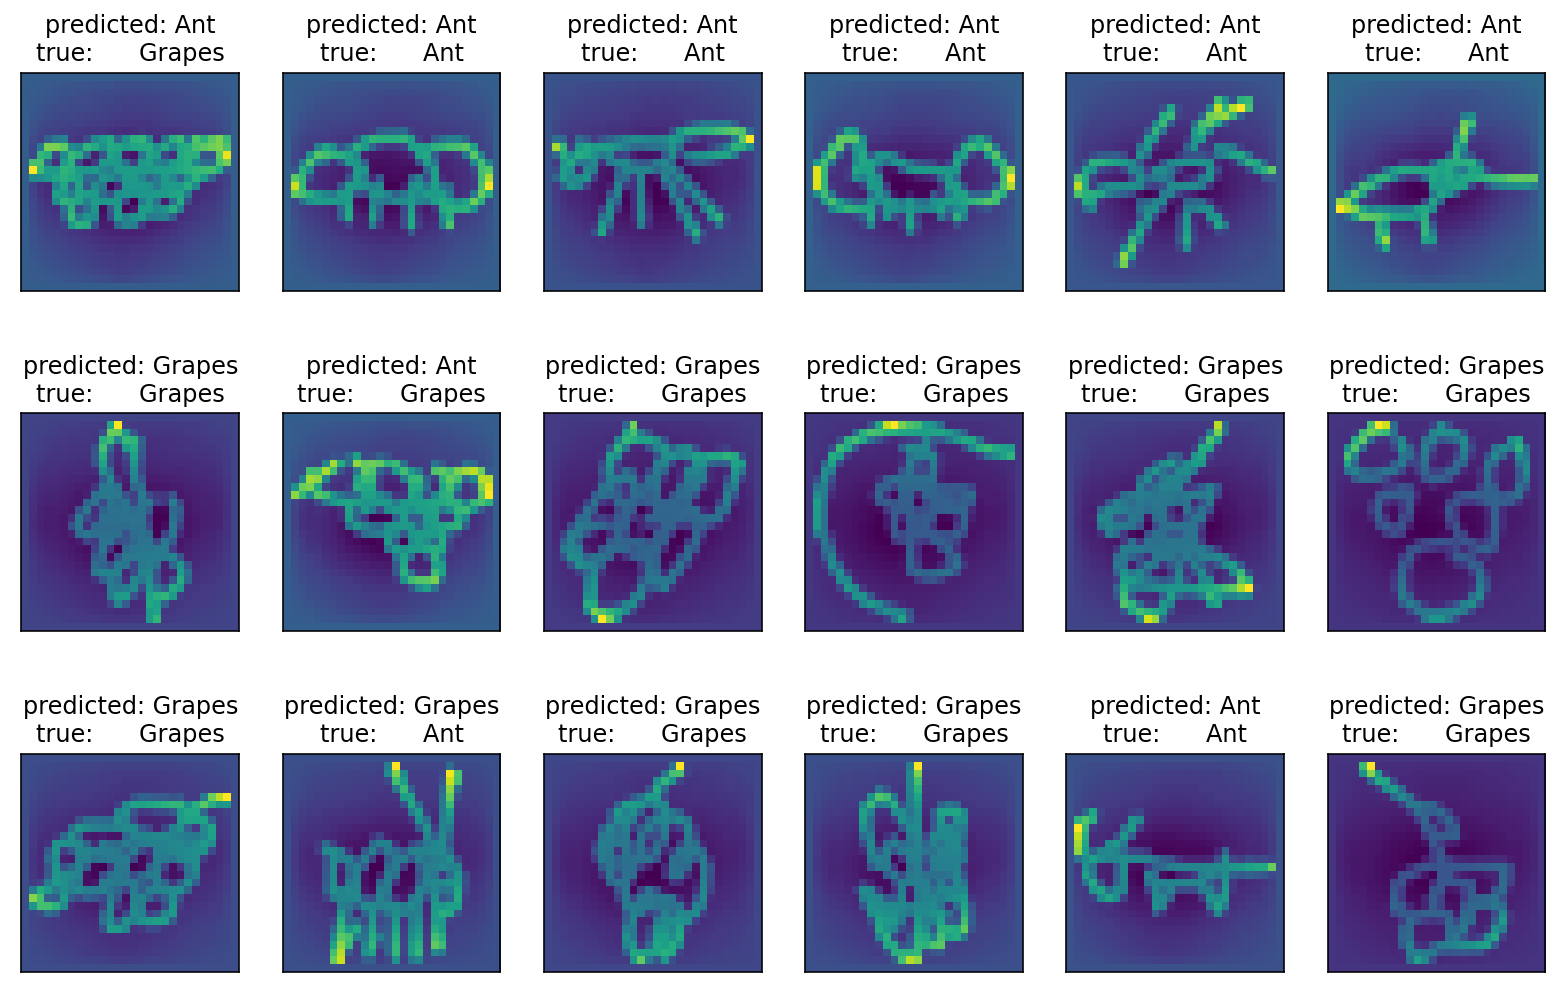

In [27]:
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    samples = np.random.randint(0, images.shape[0], size=n_row*n_col)
    for i,j in enumerate(samples):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[j].reshape(28,28,))
        plt.title(titles[j], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

y_pred_rfc = rfc.predict(X_test)
prediction_titles = [title(y_pred_rfc[i], y_test[i], names)
                     for i in range(y_pred_rfc.shape[0])]

plot_gallery(X_test, prediction_titles)
plt.show()

In order to visualise the images and see how our Random Forest Classifier performs, we have plotted some of the images (taken at random in the test set) with theire true label and the predicted one. On average, our model makes 2 or 3 mistakes over the 24 images that we plot at a single time.

# Conclusions

To sum up, we consider that the Random Forest Classifier is the one that performs best for the binary classification. Indeed, it is the model that does not significantly overfit (when limiting the depth of the trees) and that still perform quite well on the test set. The results obtained are quite good as the images are sometimes really hard to label, even for a human (when plotting the images, some of them are really difficult to determine, and it is often on those images that the model is wrong). This shows that our model is quite good at finding the patterns to recognise ants and grapes.